# Allstate reverse search experiment

In [1]:
import polars as pl
import polars.selectors as cs
from sklearn import cluster
import numpy as np
import seaborn as sns
from collections import defaultdict
from statistics import median
import json

In [2]:
df = pl.read_csv("data/train_set.csv", null_values="?")
train, validation = df.with_columns((pl.col("Row_ID") % 20 == 0).alias("split")).partition_by("split", include_key=False)

In [3]:
sample = non_zero = train.filter(pl.col("Claim_Amount") != 0.0)["Claim_Amount"].sample(fraction=0.1).to_numpy()
clustering = cluster.HDBSCAN(n_jobs=-1).fit(sample.reshape(-1, 1))

698 1198


<Axes: ylabel='Count'>

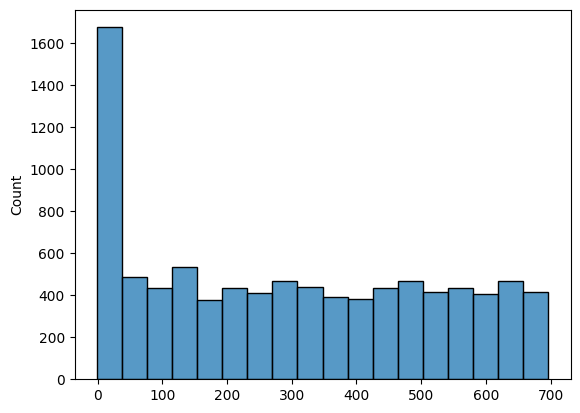

In [4]:
unique, counts = np.unique(clustering.labels_, return_counts=True)
print(len(unique), np.max(counts))
sns.histplot(clustering.labels_)


In [5]:
cluster_aggs = defaultdict(lambda : [0.0, 0])
for value, label in zip(sample, clustering.labels_):
    aggs = cluster_aggs[label]
    aggs[0] += value
    aggs[1] += 1

label_means = {label: aggs[0]/aggs[1] for label, aggs in cluster_aggs.items()}
print(label_means)

cluster_partitioned = defaultdict(lambda: [])
for value, label in zip(sample, clustering.labels_):
    cluster_partitioned[label].append(value)
label_medians = {label: median(partition) for label, partition in cluster_partitioned.items()}
def rename_cluster(label):
    tmp_val = label_medians[label]
    del label_medians[label]
    max_label = max(label_medians.keys())
    label_medians[max_label + 1] = tmp_val

rename_cluster(-1)
rename_cluster(0) # Reserve 0 for the 0th label
label_medians[0] = 0.
print(label_medians)

{399: 41.53249684210525, 317: 72.486788, -1: 232.5957572846407, 438: 59.23246454545454, 368: 19.317437222222217, 688: 1.4298860833333336, 108: 347.8372333333333, 578: 7.953155142857143, 415: 46.58652333333333, 204: 99.50092, 81: 670.8616875, 536: 10.069941111111111, 135: 316.4772064516129, 139: 235.02457222222222, 388: 34.13436299999999, 310: 84.45307631578946, 468: 43.951595555555556, 473: 16.776252777777774, 4: 2817.2757142857145, 485: 18.227295714285713, 518: 10.983258235294116, 396: 9.160878411764706, 305: 30.884341666666668, 627: 7.903595545454545, 564: 4.893397833333334, 548: 4.965674294117647, 509: 17.236067333333327, 232: 74.84093800000001, 694: 1.481826105263158, 467: 43.610161250000004, 144: 266.11973333333333, 462: 0.034041477, 449: 44.30861636363637, 46: 575.0566625, 556: 12.284814117647059, 490: 5.5897755, 668: 3.8283433749999998, 560: 6.307042, 125: 162.34950952380953, 176: 243.99332222222222, 217: 88.39766444444444, 143: 210.75905000000003, 279: 50.04799499999999, 645: 9

In [6]:
print(len(label_medians))
print(max(label_medians.keys()))
print(len(label_means))

699
698
698


<Axes: ylabel='Count'>

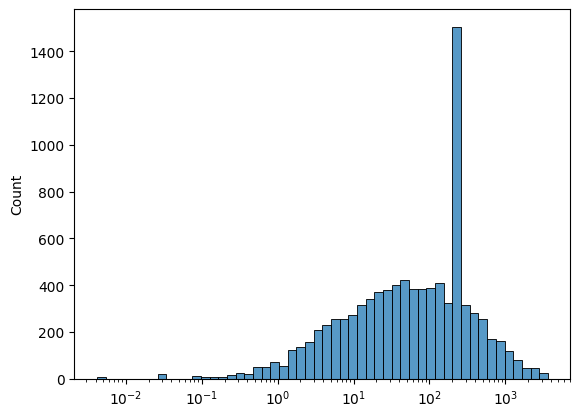

In [7]:
filtered_labelled = [label_means[label] for label in clustering.labels_]
sns.histplot(filtered_labelled, log_scale=True)

In [8]:
validation_response = validation["Claim_Amount"]

errors = []
for response in validation_response:
    errors.append(min([abs(response - median) for median in label_medians.values()]))
print(sum(errors) / len(errors))
        

0.018322227371319926


In [67]:
non_zero = train.filter(pl.col("Claim_Amount") != 0.0)["Claim_Amount"].to_numpy()
print(len(df), len(train), len(non_zero))
full_clustering = cluster.HDBSCAN(n_jobs=-1).fit(non_zero.reshape(-1, 1))

13184290 12525076 90822


In [68]:
print(len(np.unique(full_clustering.labels_)))

6957


# Build up the sparse representation


In [9]:
sparse = df.clone()

In [10]:
# Do something useful with model age
sparse = sparse.with_columns((pl.col("Model_Year") - pl.col("Calendar_Year")).alias("Year_Delta"))

In [11]:
sparse = sparse.drop("Household_ID", "Calendar_Year", "Model_Year", "Blind_Submodel")

In [12]:
medians = []
for label in sorted(label_medians.keys()):
    medians.append(label_medians[label])
medians_ary = np.array(medians)

def get_cluster(response):
    errors = np.absolute((medians_ary - response))
    return errors.argmin()
cluster_ids = sparse["Claim_Amount"].map_elements(get_cluster, pl.Int32)
sparse = pl.concat([sparse, cluster_ids.to_frame("Cluster_ID")], how="horizontal")

In [116]:
clustered = cluster_ids.replace_strict(label_medians).to_frame("clustered")
compare = pl.concat([clustered, sparse["Claim_Amount"].to_frame()], how="horizontal")
compare = compare.with_columns((pl.col("clustered") - pl.col("Claim_Amount")).alias("diff"))

In [13]:
sparse = sparse.to_dummies(["OrdCat", cs.string(include_categorical=True)])

In [14]:
for col in sparse.columns:
    print(col, end=', ')

Row_ID, Vehicle, Blind_Make_A, Blind_Make_AB, Blind_Make_AC, Blind_Make_AD, Blind_Make_AE, Blind_Make_AF, Blind_Make_AG, Blind_Make_AH, Blind_Make_AI, Blind_Make_AJ, Blind_Make_AK, Blind_Make_AL, Blind_Make_AM, Blind_Make_AN, Blind_Make_AO, Blind_Make_AP, Blind_Make_AQ, Blind_Make_AR, Blind_Make_AS, Blind_Make_AT, Blind_Make_AU, Blind_Make_AV, Blind_Make_AW, Blind_Make_AX, Blind_Make_AY, Blind_Make_AZ, Blind_Make_B, Blind_Make_BA, Blind_Make_BB, Blind_Make_BC, Blind_Make_BD, Blind_Make_BF, Blind_Make_BG, Blind_Make_BH, Blind_Make_BK, Blind_Make_BL, Blind_Make_BM, Blind_Make_BN, Blind_Make_BO, Blind_Make_BP, Blind_Make_BQ, Blind_Make_BR, Blind_Make_BS, Blind_Make_BT, Blind_Make_BU, Blind_Make_BV, Blind_Make_BW, Blind_Make_BY, Blind_Make_BZ, Blind_Make_C, Blind_Make_CA, Blind_Make_CB, Blind_Make_D, Blind_Make_E, Blind_Make_F, Blind_Make_G, Blind_Make_H, Blind_Make_I, Blind_Make_J, Blind_Make_K, Blind_Make_L, Blind_Make_M, Blind_Make_N, Blind_Make_O, Blind_Make_P, Blind_Make_Q, Blind_Make

In [17]:
train, validation = sparse.with_columns((pl.col("Row_ID") % 20 == 0).alias("split")).partition_by("split", include_key=False)
train = train.drop("Row_ID")
validation = validation.drop("Row_ID")

In [18]:
clusters_df = pl.DataFrame({"label": label_medians.keys(), "cluster_medians": label_medians.values()})
train.write_parquet("data/rs_train.parquet")
validation.write_parquet("data/rs_validation.parquet")